# DEEP LEARNING PROJECT 1
---

In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

import matplotlib.pyplot as plt
import torch.nn as nn
from torchsummary import summary
import torch
import torch.utils.data as data

import helpers
import config
from datasets import PairDataset, SingleDataset

from train.train import train_basic
from train.train import train_siamese

from models.basic_net import BasicNet
from models.oscar_net import OscarNet
from models.desmond_net import DesmondNet
from models.robert_net import RobertNet
from models.leonard_net import LeonardNet

## PARAMETERS

In [2]:
INPUT_SIZE = (2, 14, 14)

LEARNING_RATE = 0.00001
SUB_CRITERION = nn.CrossEntropyLoss()
FINAL_CRITERION = nn.BCELoss()
EPOCHS = 20

NET_HIDDEN_LAYER = 512
BASE_CHANNEL_SIZE = 8

TRAIN_BATCH_SIZE = 1

ALPHA = 0.5
BETA = 0.25
GAMMA = 0.25
WEIGHTS_LOSS = ALPHA, BETA, GAMMA

## Load Data

In [3]:
pairs = helpers.generate_pair_sets(config.NB_SAMPLES)

train_dataset = PairDataset(pairs[0], pairs[1], pairs[2])
train_dataloader = data.DataLoader(dataset=train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

test_dataset = PairDataset(pairs[3], pairs[4], pairs[5])
test_dataloader = data.DataLoader(dataset=test_dataset, batch_size=config.TEST_BATCH_SIZE, shuffle=True)

## Model 1: 
## Basic model

In [4]:
model1 = BasicNet(1, NET_HIDDEN_LAYER)

In [5]:
summary(model1, INPUT_SIZE) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         201,216
            Linear-2                    [-1, 1]             513
Total params: 201,729
Trainable params: 201,729
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.77
Estimated Total Size (MB): 0.77
----------------------------------------------------------------


In [6]:
tr_loss1, tr_acc1, te_loss1, te_acc1 = train_basic(model = model1,
                                   dataloader = train_dataloader,
                                   test_dataloader = test_dataloader,
                                   epochs = EPOCHS,
                                   final_criterion = FINAL_CRITERION,
                                   learning_rate = LEARNING_RATE)

NO CUDA
[Epoch 1, Batch 0/1000]:  [Loss: 17.84]
[Epoch 1, Batch 250/1000]:  [Loss: 15.41]
[Epoch 1, Batch 500/1000]:  [Loss: 0.14]
[Epoch 1, Batch 750/1000]:  [Loss: 0.00]
At epoch 1 the loss is 3.007769041380966
At epoch 1 the accuracy is 0.584
The test loss is 2.409115791320801
The test accuracy is 0.623
[Epoch 2, Batch 0/1000]:  [Loss: 1.34]
[Epoch 2, Batch 250/1000]:  [Loss: 0.04]
[Epoch 2, Batch 500/1000]:  [Loss: 0.35]
[Epoch 2, Batch 750/1000]:  [Loss: 0.10]
At epoch 2 the loss is 1.6647903650996978
At epoch 2 the accuracy is 0.705
The test loss is 1.8741552829742432
The test accuracy is 0.689
[Epoch 3, Batch 0/1000]:  [Loss: 0.18]
[Epoch 3, Batch 250/1000]:  [Loss: 0.00]
[Epoch 3, Batch 500/1000]:  [Loss: 0.00]
[Epoch 3, Batch 750/1000]:  [Loss: 1.43]
At epoch 3 the loss is 1.2131184782213034
At epoch 3 the accuracy is 0.77
The test loss is 1.5868874788284302
The test accuracy is 0.692
[Epoch 4, Batch 0/1000]:  [Loss: 2.34]
[Epoch 4, Batch 250/1000]:  [Loss: 0.00]
[Epoch 4, Bat

Text(0, 0.5, 'Accuracy')

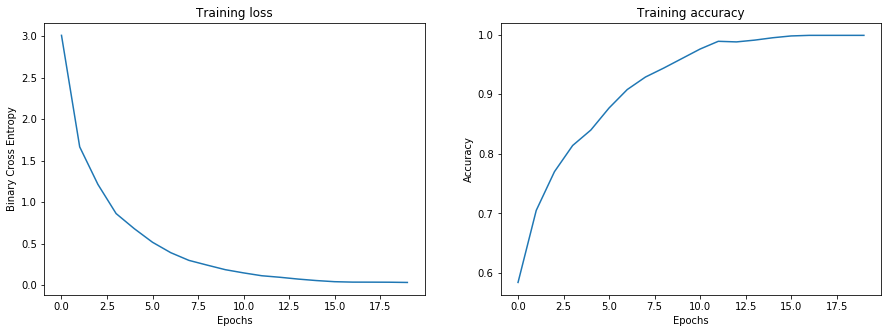

In [7]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

plt.plot(range(1, EPOCHS+1), tr_loss1)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Training loss')

plt.subplot(1,2,2)
plt.plot(range(1, EPOCHS+1), tr_acc1)
plt.title('Training accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Last test accuracy :0.771


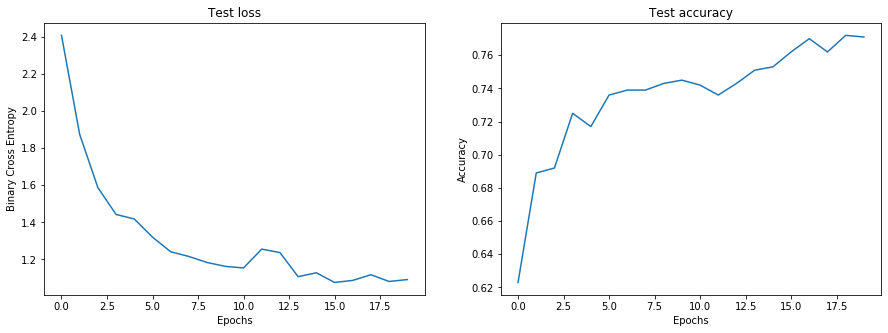

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

plt.plot(range(1, EPOCHS+1), te_loss1)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Test loss')

plt.subplot(1,2,2)
plt.plot(range(1, EPOCHS+1), te_acc1)
plt.title('Test accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

print("Last test accuracy :" + str(te_acc1[-1]))

## Model 2: 
## Desmond model (Siamese with Oscars (FCNs for classification) - No weight sharing - No aux-loss)

In [9]:
oscar21 = OscarNet(1, NET_HIDDEN_LAYER)
oscar22 = OscarNet(1, NET_HIDDEN_LAYER)
model2 = DesmondNet(1, oscar21, oscar22, NET_HIDDEN_LAYER)

In [10]:
summary(model2, INPUT_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         100,864
            Linear-2                   [-1, 10]           5,130
          OscarNet-3       [[-1, 10], [-1, 10]]               0
            Linear-4                  [-1, 512]         100,864
            Linear-5                   [-1, 10]           5,130
          OscarNet-6       [[-1, 10], [-1, 10]]               0
            Linear-7                  [-1, 512]          10,752
            Linear-8                    [-1, 1]             513
Total params: 223,253
Trainable params: 223,253
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.85
Estimated Total Size (MB): 0.86
----------------------------------------------------------------


In [11]:
tr_loss2, tr_acc2, tr_loss2_l, tr_loss2_r, te_loss2, te_acc2, te_loss2_l, te_loss2_r = train_siamese(model = model2,
                                     dataloader = train_dataloader,
                                     test_dataloader = test_dataloader,
                                     epochs = EPOCHS,
                                     final_criterion = FINAL_CRITERION, 
                                     learning_rate = LEARNING_RATE)

NO CUDA
[Epoch 1, Batch 0/1000]:  [Loss: 0.68]
[Epoch 1, Batch 250/1000]:  [Loss: 0.63]
[Epoch 1, Batch 500/1000]:  [Loss: 0.77]
[Epoch 1, Batch 750/1000]:  [Loss: 0.66]
At epoch 1 the training loss is 0.6896938022971153
At epoch 1 the training accuracy is 0.547
At epoch 1 :
The test loss is 0.6831432580947876
The test accuracy is 0.568
[Epoch 2, Batch 0/1000]:  [Loss: 0.73]
[Epoch 2, Batch 250/1000]:  [Loss: 0.62]
[Epoch 2, Batch 500/1000]:  [Loss: 0.66]
[Epoch 2, Batch 750/1000]:  [Loss: 0.66]
At epoch 2 the training loss is 0.6783901482820511
At epoch 2 the training accuracy is 0.559
At epoch 2 :
The test loss is 0.6738044619560242
The test accuracy is 0.566
[Epoch 3, Batch 0/1000]:  [Loss: 0.65]
[Epoch 3, Batch 250/1000]:  [Loss: 0.84]
[Epoch 3, Batch 500/1000]:  [Loss: 0.82]
[Epoch 3, Batch 750/1000]:  [Loss: 0.61]
At epoch 3 the training loss is 0.6663783002495766
At epoch 3 the training accuracy is 0.57
At epoch 3 :
The test loss is 0.664452314376831
The test accuracy is 0.598
[

Text(0.5, 1.0, 'Training loss (right brother)')

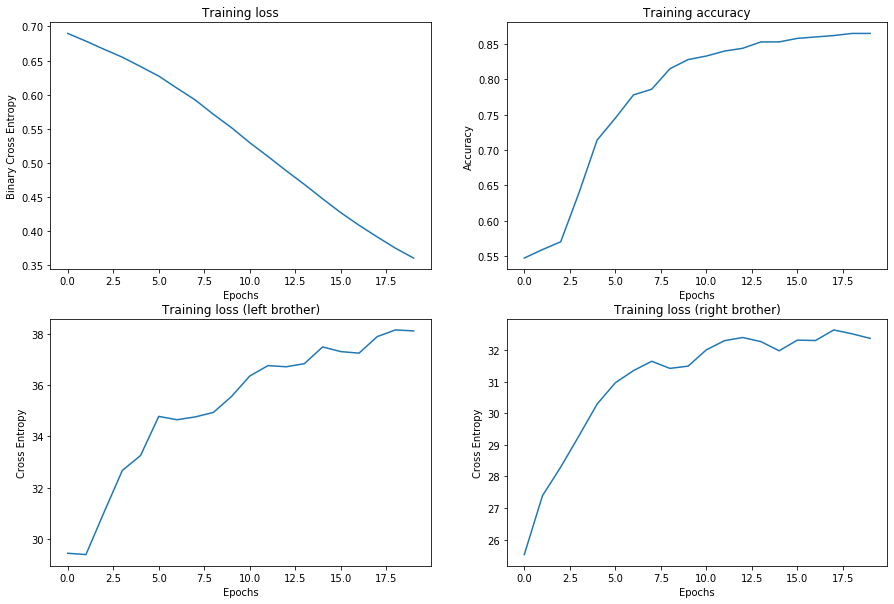

In [12]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), tr_loss2)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Training loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), tr_acc2)
plt.title('Training accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), tr_loss2_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), tr_loss2_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (right brother)')

Last test accuracy :0.74


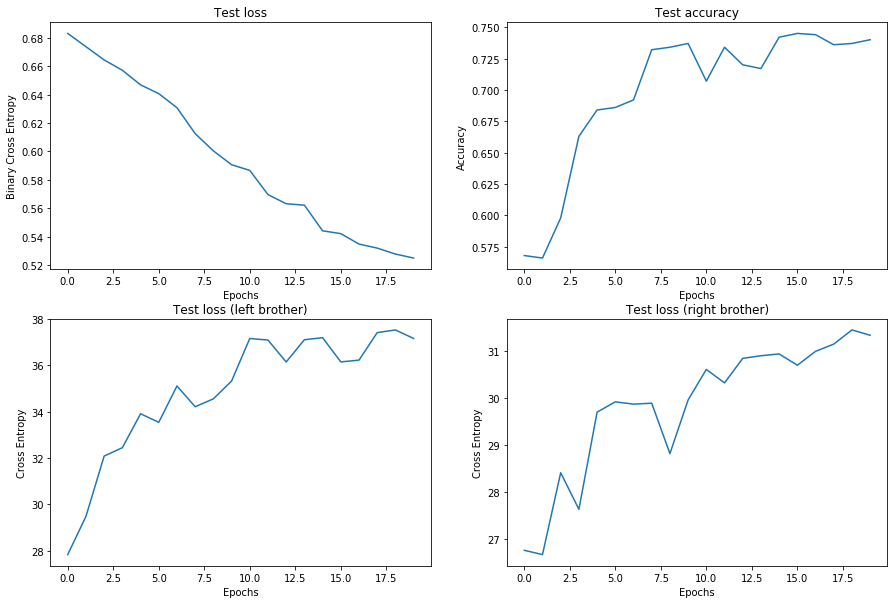

In [13]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), te_loss2)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Test loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), te_acc2)
plt.title('Test accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), te_loss2_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), te_loss2_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (right brother)')

print("Last test accuracy :" + str(te_acc2[-1]))

## Model 3: 
## Desmond model (Siamese with Oscars (FCNs for classification) - No weight sharing - Aux-loss)

In [14]:
oscar31 = OscarNet(1, NET_HIDDEN_LAYER)
oscar32 = OscarNet(1, NET_HIDDEN_LAYER)
model3 = DesmondNet(1, oscar31, oscar32, NET_HIDDEN_LAYER)

In [15]:
summary(model3, INPUT_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         100,864
            Linear-2                   [-1, 10]           5,130
          OscarNet-3       [[-1, 10], [-1, 10]]               0
            Linear-4                  [-1, 512]         100,864
            Linear-5                   [-1, 10]           5,130
          OscarNet-6       [[-1, 10], [-1, 10]]               0
            Linear-7                  [-1, 512]          10,752
            Linear-8                    [-1, 1]             513
Total params: 223,253
Trainable params: 223,253
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.85
Estimated Total Size (MB): 0.86
----------------------------------------------------------------


In [16]:
tr_loss3, tr_acc3, tr_loss3_l, tr_loss3_r, te_loss3, te_acc3, te_loss3_l, te_loss3_r = train_siamese(model = model3,
                                     dataloader = train_dataloader,
                                     test_dataloader = test_dataloader,
                                     epochs = EPOCHS,
                                     final_criterion = FINAL_CRITERION, 
                                     learning_rate = LEARNING_RATE,
                                     aux_loss = True,
                                     sub_criterion = SUB_CRITERION, 
                                     weights_loss = WEIGHTS_LOSS)

NO CUDA
[Epoch 1, Batch 0/1000]:  [Loss: 14.19]
[Epoch 1, Batch 250/1000]:  [Loss: 0.52]
[Epoch 1, Batch 500/1000]:  [Loss: 5.21]
[Epoch 1, Batch 750/1000]:  [Loss: 0.97]
At epoch 1 the training loss is 7.7268801844120025
At epoch 1 the training accuracy is 0.439
At epoch 1 :
The test loss is 4.894037246704102
The test accuracy is 0.448
[Epoch 2, Batch 0/1000]:  [Loss: 2.40]
[Epoch 2, Batch 250/1000]:  [Loss: 5.97]
[Epoch 2, Batch 500/1000]:  [Loss: 4.82]
[Epoch 2, Batch 750/1000]:  [Loss: 0.35]
At epoch 2 the training loss is 3.3041663782596586
At epoch 2 the training accuracy is 0.503
At epoch 2 :
The test loss is 2.9630126953125
The test accuracy is 0.609
[Epoch 3, Batch 0/1000]:  [Loss: 0.60]
[Epoch 3, Batch 250/1000]:  [Loss: 2.37]
[Epoch 3, Batch 500/1000]:  [Loss: 5.98]
[Epoch 3, Batch 750/1000]:  [Loss: 1.63]
At epoch 3 the training loss is 2.0509619385302065
At epoch 3 the training accuracy is 0.613
At epoch 3 :
The test loss is 2.215162992477417
The test accuracy is 0.631
[Ep

Text(0.5, 1.0, 'Training loss (right brother)')

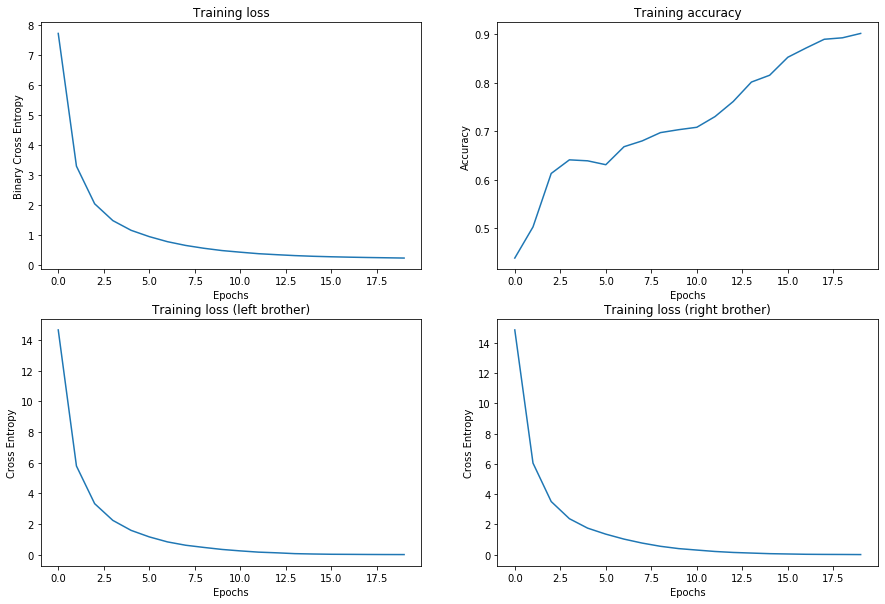

In [17]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), tr_loss3)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Training loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), tr_acc3)
plt.title('Training accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), tr_loss3_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), tr_loss3_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (right brother)')

Last test accuracy :0.828


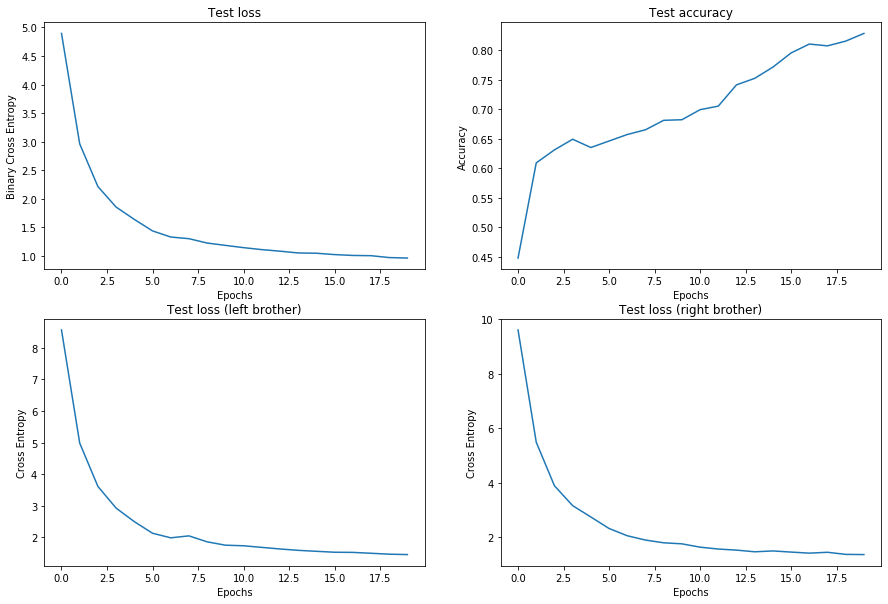

In [19]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), te_loss3)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Test loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), te_acc3)
plt.title('Test accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), te_loss3_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), te_loss3_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (right brother)')

print("Last test accuracy :" + str(te_acc3[-1]))

## Model 4: 
## Desmond model (Siamese with Roberts (Simple CNNs with FCNs for classification) - No weight sharing - No aux-loss)

In [20]:
robert41 = RobertNet(1, BASE_CHANNEL_SIZE, NET_HIDDEN_LAYER)
robert42 = RobertNet(1, BASE_CHANNEL_SIZE, NET_HIDDEN_LAYER)
model4 = DesmondNet(1, robert41, robert42, NET_HIDDEN_LAYER)

In [21]:
summary(model4, INPUT_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 12, 12]             160
         LeakyReLU-2           [-1, 16, 12, 12]               0
            Conv2d-3           [-1, 32, 10, 10]           4,640
         LeakyReLU-4           [-1, 32, 10, 10]               0
         MaxPool2d-5             [-1, 32, 5, 5]               0
            Linear-6                  [-1, 512]         410,112
            Linear-7                   [-1, 10]           5,130
         RobertNet-8       [[-1, 10], [-1, 10]]               0
            Conv2d-9           [-1, 16, 12, 12]             160
        LeakyReLU-10           [-1, 16, 12, 12]               0
           Conv2d-11           [-1, 32, 10, 10]           4,640
        LeakyReLU-12           [-1, 32, 10, 10]               0
        MaxPool2d-13             [-1, 32, 5, 5]               0
           Linear-14                  [

In [22]:
tr_loss4, tr_acc4, tr_loss4_l, tr_loss4_r, te_loss4, te_acc4, te_loss4_l, te_loss4_r = train_siamese(model = model4,
                                     dataloader = train_dataloader,
                                     test_dataloader = test_dataloader,
                                     epochs = EPOCHS,
                                     final_criterion = FINAL_CRITERION, 
                                     learning_rate = LEARNING_RATE)

NO CUDA
[Epoch 1, Batch 0/1000]:  [Loss: 0.74]
[Epoch 1, Batch 250/1000]:  [Loss: 0.73]
[Epoch 1, Batch 500/1000]:  [Loss: 0.65]
[Epoch 1, Batch 750/1000]:  [Loss: 0.74]
At epoch 1 the training loss is 0.687226356625557
At epoch 1 the training accuracy is 0.558
At epoch 1 :
The test loss is 0.6772876977920532
The test accuracy is 0.564
[Epoch 2, Batch 0/1000]:  [Loss: 0.74]
[Epoch 2, Batch 250/1000]:  [Loss: 0.74]
[Epoch 2, Batch 500/1000]:  [Loss: 0.58]
[Epoch 2, Batch 750/1000]:  [Loss: 0.73]
At epoch 2 the training loss is 0.6723902879357337
At epoch 2 the training accuracy is 0.558
At epoch 2 :
The test loss is 0.6642749905586243
The test accuracy is 0.564
[Epoch 3, Batch 0/1000]:  [Loss: 0.55]
[Epoch 3, Batch 250/1000]:  [Loss: 0.72]
[Epoch 3, Batch 500/1000]:  [Loss: 0.71]
[Epoch 3, Batch 750/1000]:  [Loss: 0.53]
At epoch 3 the training loss is 0.6581881338953972
At epoch 3 the training accuracy is 0.558
At epoch 3 :
The test loss is 0.6508585214614868
The test accuracy is 0.564


Text(0.5, 1.0, 'Training loss (right brother)')

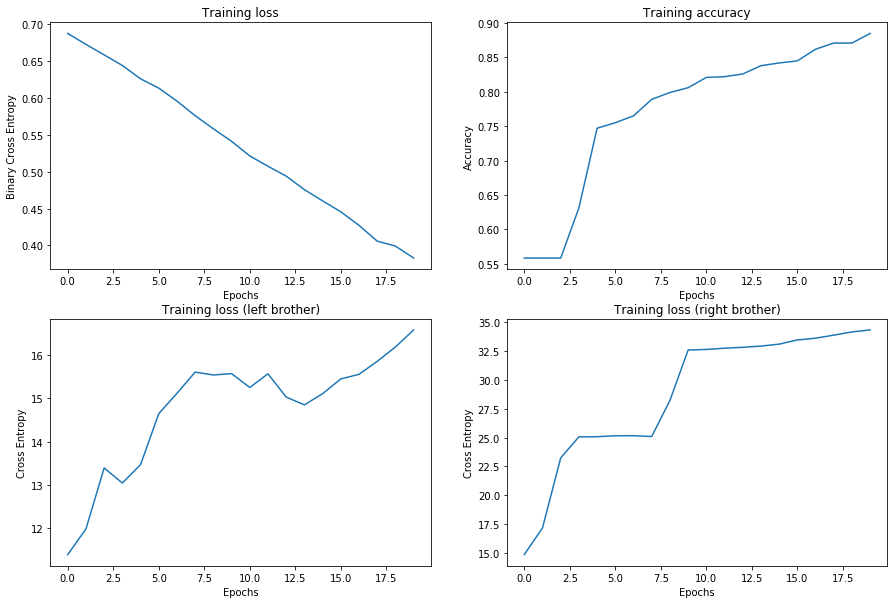

In [23]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), tr_loss4)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Training loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), tr_acc4)
plt.title('Training accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), tr_loss4_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), tr_loss4_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (right brother)')

Last test accuracy :0.699


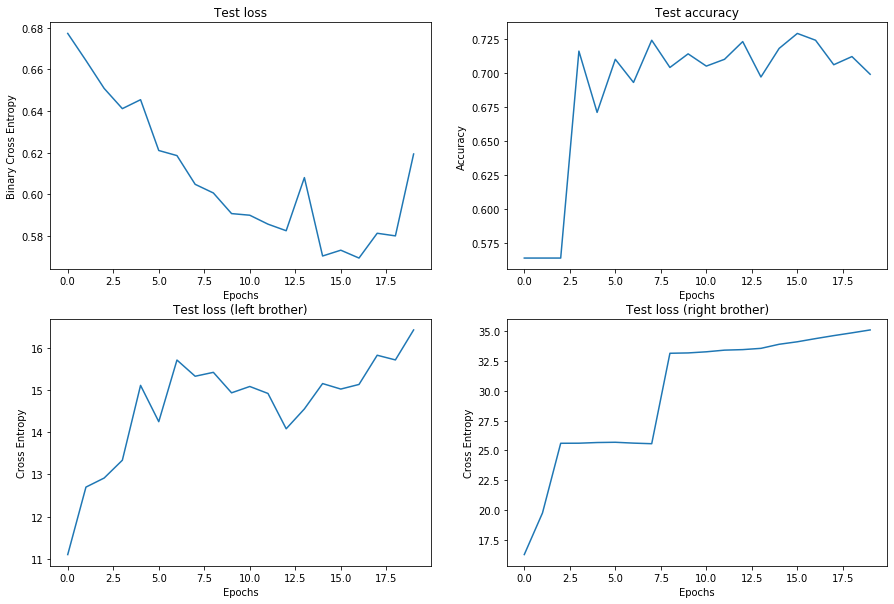

In [24]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), te_loss4)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Test loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), te_acc4)
plt.title('Test accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), te_loss4_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), te_loss4_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (right brother)')

print("Last test accuracy :" + str(te_acc4[-1]))

## Model 5: 
## Desmond model (Siamese with Roberts (Simple CNNs with FCNs for classification) - No weight sharing - Aux-loss)

In [25]:
robert51 = RobertNet(1, BASE_CHANNEL_SIZE, NET_HIDDEN_LAYER)
robert52 = RobertNet(1, BASE_CHANNEL_SIZE, NET_HIDDEN_LAYER)
model5 = DesmondNet(1, robert51, robert52, NET_HIDDEN_LAYER)

In [26]:
summary(model5, INPUT_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 12, 12]             160
         LeakyReLU-2           [-1, 16, 12, 12]               0
            Conv2d-3           [-1, 32, 10, 10]           4,640
         LeakyReLU-4           [-1, 32, 10, 10]               0
         MaxPool2d-5             [-1, 32, 5, 5]               0
            Linear-6                  [-1, 512]         410,112
            Linear-7                   [-1, 10]           5,130
         RobertNet-8       [[-1, 10], [-1, 10]]               0
            Conv2d-9           [-1, 16, 12, 12]             160
        LeakyReLU-10           [-1, 16, 12, 12]               0
           Conv2d-11           [-1, 32, 10, 10]           4,640
        LeakyReLU-12           [-1, 32, 10, 10]               0
        MaxPool2d-13             [-1, 32, 5, 5]               0
           Linear-14                  [

In [27]:
tr_loss5, tr_acc5, tr_loss5_l, tr_loss5_r, te_loss5, te_acc5, te_loss5_l, te_loss5_r = train_siamese(model = model5,
                                     dataloader = train_dataloader,
                                     test_dataloader = test_dataloader,
                                     epochs = EPOCHS,
                                     final_criterion = FINAL_CRITERION, 
                                     learning_rate = LEARNING_RATE,
                                     aux_loss = True,
                                     sub_criterion = SUB_CRITERION, 
                                     weights_loss = WEIGHTS_LOSS)

NO CUDA
[Epoch 1, Batch 0/1000]:  [Loss: 7.57]
[Epoch 1, Batch 250/1000]:  [Loss: 1.38]
[Epoch 1, Batch 500/1000]:  [Loss: 0.59]
[Epoch 1, Batch 750/1000]:  [Loss: 1.16]
At epoch 1 the training loss is 1.4281867669522763
At epoch 1 the training accuracy is 0.558
At epoch 1 :
The test loss is 0.7553703784942627
The test accuracy is 0.564
[Epoch 2, Batch 0/1000]:  [Loss: 0.43]
[Epoch 2, Batch 250/1000]:  [Loss: 1.27]
[Epoch 2, Batch 500/1000]:  [Loss: 0.44]
[Epoch 2, Batch 750/1000]:  [Loss: 1.38]
At epoch 2 the training loss is 0.6491438828706741
At epoch 2 the training accuracy is 0.558
At epoch 2 :
The test loss is 0.5897114276885986
The test accuracy is 0.564
[Epoch 3, Batch 0/1000]:  [Loss: 0.41]
[Epoch 3, Batch 250/1000]:  [Loss: 0.57]
[Epoch 3, Batch 500/1000]:  [Loss: 0.30]
[Epoch 3, Batch 750/1000]:  [Loss: 0.39]
At epoch 3 the training loss is 0.5207409610748291
At epoch 3 the training accuracy is 0.558
At epoch 3 :
The test loss is 0.5295335054397583
The test accuracy is 0.564

Text(0.5, 1.0, 'Training loss (right brother)')

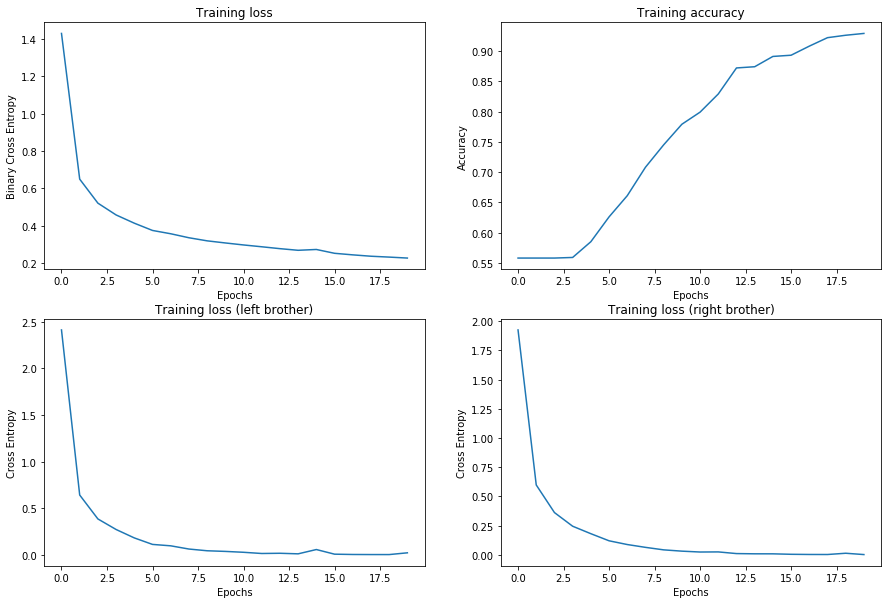

In [28]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), tr_loss5)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Training loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), tr_acc5)
plt.title('Training accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), tr_loss5_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), tr_loss5_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (right brother)')

Last test accuracy :0.89


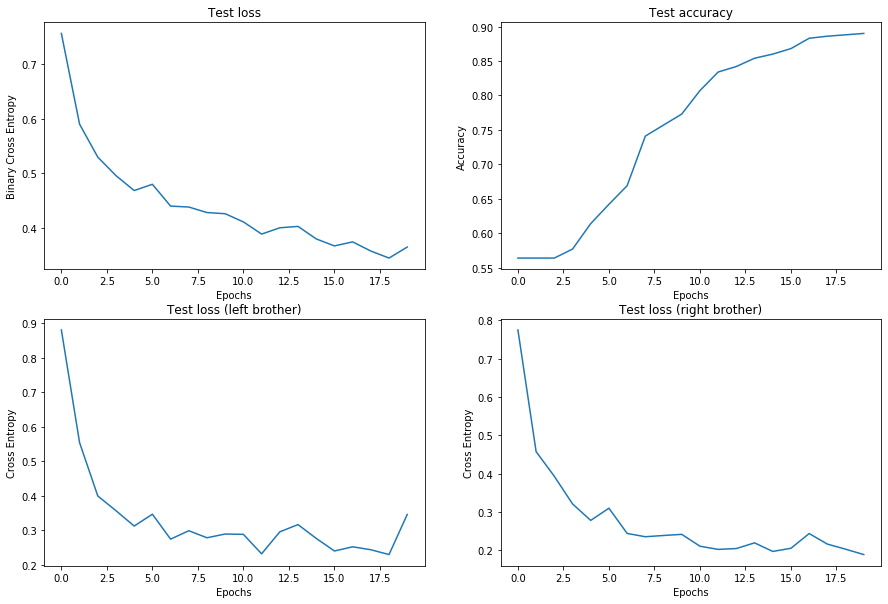

In [29]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), te_loss5)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Test loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), te_acc5)
plt.title('Test accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), te_loss5_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), te_loss5_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (right brother)')

print("Last test accuracy :" + str(te_acc5[-1]))

## Model 6: 
## Leonard model (Siamese with Oscars (FCNs for classification) - Weight sharing - No aux-loss)

In [30]:
oscar6 = OscarNet(1, NET_HIDDEN_LAYER)
model6 = LeonardNet(1, oscar6, NET_HIDDEN_LAYER)

In [31]:
summary(model6, INPUT_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         100,864
            Linear-2                   [-1, 10]           5,130
          OscarNet-3       [[-1, 10], [-1, 10]]               0
            Linear-4                  [-1, 512]         100,864
            Linear-5                   [-1, 10]           5,130
          OscarNet-6       [[-1, 10], [-1, 10]]               0
            Linear-7                  [-1, 512]          10,752
            Linear-8                    [-1, 1]             513
Total params: 223,253
Trainable params: 223,253
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.85
Estimated Total Size (MB): 0.86
----------------------------------------------------------------


In [32]:
tr_loss6, tr_acc6, tr_loss6_l, tr_loss6_r, te_loss6, te_acc6, te_loss6_l, te_loss6_r = train_siamese(model = model6,
                                     dataloader = train_dataloader,
                                     test_dataloader = test_dataloader,
                                     epochs = EPOCHS,
                                     final_criterion = FINAL_CRITERION, 
                                     learning_rate = LEARNING_RATE)

NO CUDA
[Epoch 1, Batch 0/1000]:  [Loss: 0.69]
[Epoch 1, Batch 250/1000]:  [Loss: 0.69]
[Epoch 1, Batch 500/1000]:  [Loss: 0.66]
[Epoch 1, Batch 750/1000]:  [Loss: 0.64]
At epoch 1 the training loss is 0.6892313319444656
At epoch 1 the training accuracy is 0.557
At epoch 1 :
The test loss is 0.6865442991256714
The test accuracy is 0.562
[Epoch 2, Batch 0/1000]:  [Loss: 0.64]
[Epoch 2, Batch 250/1000]:  [Loss: 0.63]
[Epoch 2, Batch 500/1000]:  [Loss: 0.73]
[Epoch 2, Batch 750/1000]:  [Loss: 0.65]
At epoch 2 the training loss is 0.683780358850956
At epoch 2 the training accuracy is 0.561
At epoch 2 :
The test loss is 0.6791918277740479
The test accuracy is 0.564
[Epoch 3, Batch 0/1000]:  [Loss: 0.74]
[Epoch 3, Batch 250/1000]:  [Loss: 0.71]
[Epoch 3, Batch 500/1000]:  [Loss: 0.59]
[Epoch 3, Batch 750/1000]:  [Loss: 0.77]
At epoch 3 the training loss is 0.6753210818767548
At epoch 3 the training accuracy is 0.563
At epoch 3 :
The test loss is 0.6674718856811523
The test accuracy is 0.566


Text(0.5, 1.0, 'Training loss (right brother)')

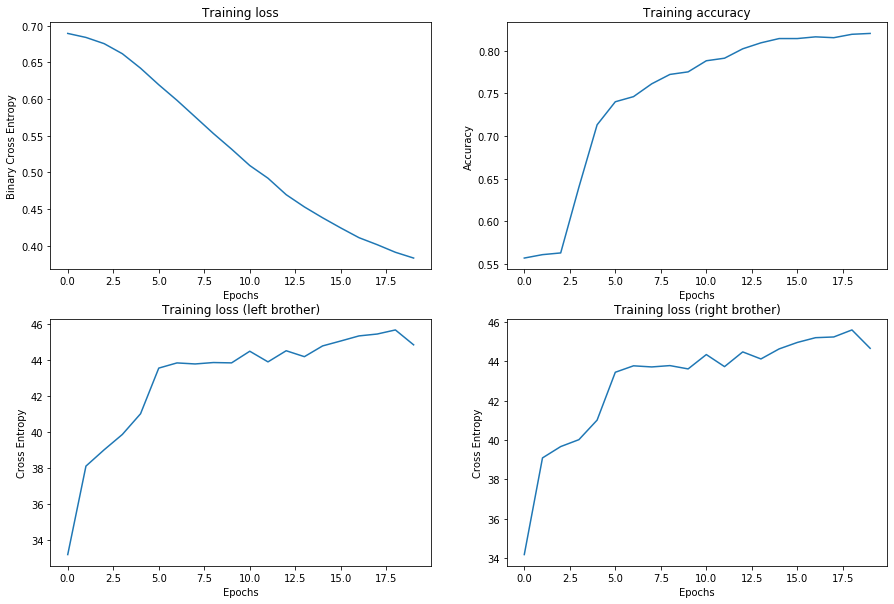

In [33]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), tr_loss6)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Training loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), tr_acc6)
plt.title('Training accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), tr_loss6_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), tr_loss6_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (right brother)')

Last test accuracy :0.755


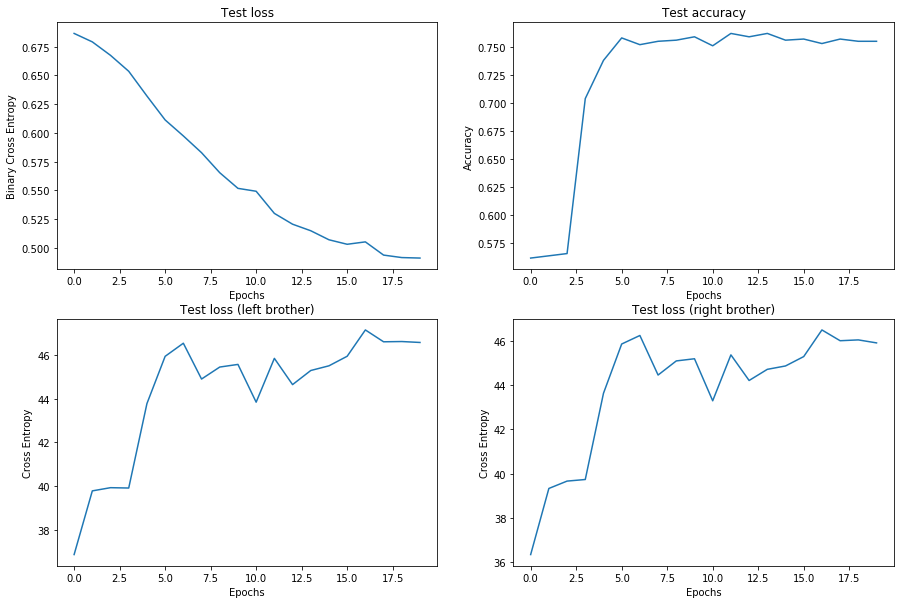

In [34]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), te_loss6)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Test loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), te_acc6)
plt.title('Test accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), te_loss6_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), te_loss6_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (right brother)')

print("Last test accuracy :" + str(te_acc6[-1]))

## Model 7: 
## Leonard model (Siamese with Oscars (FCNs for classification) - Weight sharing - Aux-loss)

In [35]:
oscar7 = OscarNet(1, NET_HIDDEN_LAYER)
model7 = LeonardNet(1, oscar7, NET_HIDDEN_LAYER)

In [36]:
summary(model7, INPUT_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         100,864
            Linear-2                   [-1, 10]           5,130
          OscarNet-3       [[-1, 10], [-1, 10]]               0
            Linear-4                  [-1, 512]         100,864
            Linear-5                   [-1, 10]           5,130
          OscarNet-6       [[-1, 10], [-1, 10]]               0
            Linear-7                  [-1, 512]          10,752
            Linear-8                    [-1, 1]             513
Total params: 223,253
Trainable params: 223,253
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.85
Estimated Total Size (MB): 0.86
----------------------------------------------------------------


In [37]:
tr_loss7, tr_acc7, tr_loss7_l, tr_loss7_r, te_loss7, te_acc7, te_loss7_l, te_loss7_r = train_siamese(model = model7,
                                     dataloader = train_dataloader,
                                     test_dataloader = test_dataloader,
                                     epochs = EPOCHS,
                                     final_criterion = FINAL_CRITERION, 
                                     learning_rate = LEARNING_RATE,
                                     aux_loss = True,
                                     sub_criterion = SUB_CRITERION, 
                                     weights_loss = WEIGHTS_LOSS)

NO CUDA
[Epoch 1, Batch 0/1000]:  [Loss: 3.99]
[Epoch 1, Batch 250/1000]:  [Loss: 0.35]
[Epoch 1, Batch 500/1000]:  [Loss: 7.30]
[Epoch 1, Batch 750/1000]:  [Loss: 1.48]
At epoch 1 the training loss is 6.566453457921743
At epoch 1 the training accuracy is 0.479
At epoch 1 :
The test loss is 3.427424907684326
The test accuracy is 0.516
[Epoch 2, Batch 0/1000]:  [Loss: 2.74]
[Epoch 2, Batch 250/1000]:  [Loss: 1.30]
[Epoch 2, Batch 500/1000]:  [Loss: 0.34]
[Epoch 2, Batch 750/1000]:  [Loss: 12.19]
At epoch 2 the training loss is 2.634619510561228
At epoch 2 the training accuracy is 0.592
At epoch 2 :
The test loss is 2.0677900314331055
The test accuracy is 0.66
[Epoch 3, Batch 0/1000]:  [Loss: 3.45]
[Epoch 3, Batch 250/1000]:  [Loss: 0.36]
[Epoch 3, Batch 500/1000]:  [Loss: 0.35]
[Epoch 3, Batch 750/1000]:  [Loss: 0.33]
At epoch 3 the training loss is 1.6645733231008053
At epoch 3 the training accuracy is 0.642
At epoch 3 :
The test loss is 1.5089643001556396
The test accuracy is 0.634
[E

Text(0.5, 1.0, 'Training loss (right brother)')

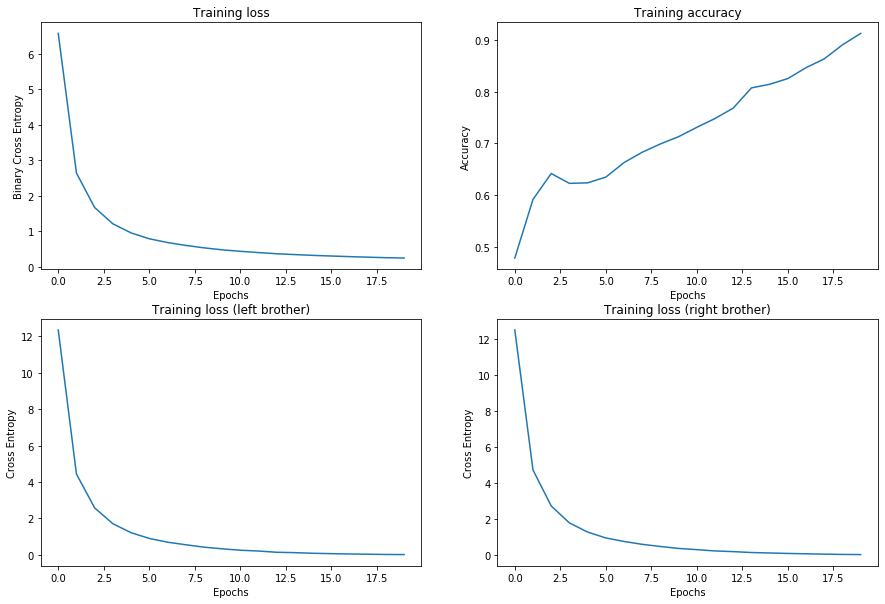

In [38]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), tr_loss7)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Training loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), tr_acc7)
plt.title('Training accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), tr_loss7_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), tr_loss7_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (right brother)')

Last test accuracy :0.843


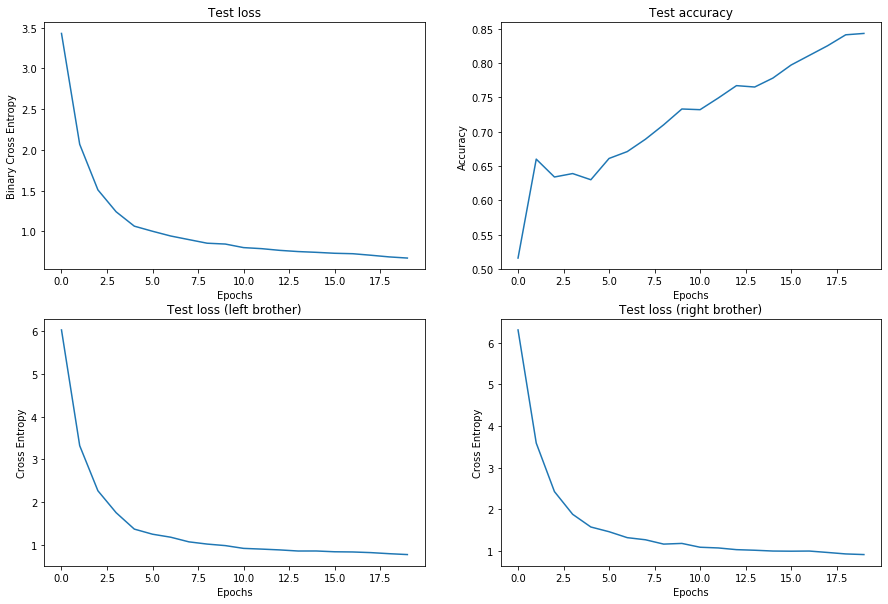

In [39]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), te_loss7)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Test loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), te_acc7)
plt.title('Test accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), te_loss7_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), te_loss7_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (right brother)')

print("Last test accuracy :" + str(te_acc7[-1]))

## Model 8: 
## Leonard model (Siamese with Roberts (Simple CNNs with FCNs for classification) - Weight sharing - No aux-loss)

In [40]:
robert8 = RobertNet(BASE_CHANNEL_SIZE, 1, NET_HIDDEN_LAYER)
model8 = LeonardNet(1, robert8, NET_HIDDEN_LAYER)

In [41]:
summary(model8, INPUT_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 12, 12]             160
         LeakyReLU-2           [-1, 16, 12, 12]               0
            Conv2d-3           [-1, 32, 10, 10]           4,640
         LeakyReLU-4           [-1, 32, 10, 10]               0
         MaxPool2d-5             [-1, 32, 5, 5]               0
            Linear-6                  [-1, 512]         410,112
            Linear-7                   [-1, 10]           5,130
         RobertNet-8       [[-1, 10], [-1, 10]]               0
            Conv2d-9           [-1, 16, 12, 12]             160
        LeakyReLU-10           [-1, 16, 12, 12]               0
           Conv2d-11           [-1, 32, 10, 10]           4,640
        LeakyReLU-12           [-1, 32, 10, 10]               0
        MaxPool2d-13             [-1, 32, 5, 5]               0
           Linear-14                  [

In [42]:
tr_loss8, tr_acc8, tr_loss8_l, tr_loss8_r, te_loss8, te_acc8, te_loss8_l, te_loss8_r = train_siamese(model = model8,
                                     dataloader = train_dataloader,
                                     test_dataloader = test_dataloader,
                                     epochs = EPOCHS,
                                     final_criterion = FINAL_CRITERION, 
                                     learning_rate = LEARNING_RATE)

NO CUDA
[Epoch 1, Batch 0/1000]:  [Loss: 0.70]
[Epoch 1, Batch 250/1000]:  [Loss: 0.65]
[Epoch 1, Batch 500/1000]:  [Loss: 0.62]
[Epoch 1, Batch 750/1000]:  [Loss: 0.79]
At epoch 1 the training loss is 0.6843136566281318
At epoch 1 the training accuracy is 0.557
At epoch 1 :
The test loss is 0.674252986907959
The test accuracy is 0.564
[Epoch 2, Batch 0/1000]:  [Loss: 0.73]
[Epoch 2, Batch 250/1000]:  [Loss: 0.71]
[Epoch 2, Batch 500/1000]:  [Loss: 0.69]
[Epoch 2, Batch 750/1000]:  [Loss: 0.68]
At epoch 2 the training loss is 0.6639958379864692
At epoch 2 the training accuracy is 0.653
At epoch 2 :
The test loss is 0.6505100727081299
The test accuracy is 0.751
[Epoch 3, Batch 0/1000]:  [Loss: 0.56]
[Epoch 3, Batch 250/1000]:  [Loss: 0.62]
[Epoch 3, Batch 500/1000]:  [Loss: 0.70]
[Epoch 3, Batch 750/1000]:  [Loss: 0.64]
At epoch 3 the training loss is 0.6395452633202076
At epoch 3 the training accuracy is 0.746
At epoch 3 :
The test loss is 0.6390805244445801
The test accuracy is 0.728


Text(0.5, 1.0, 'Training loss (right brother)')

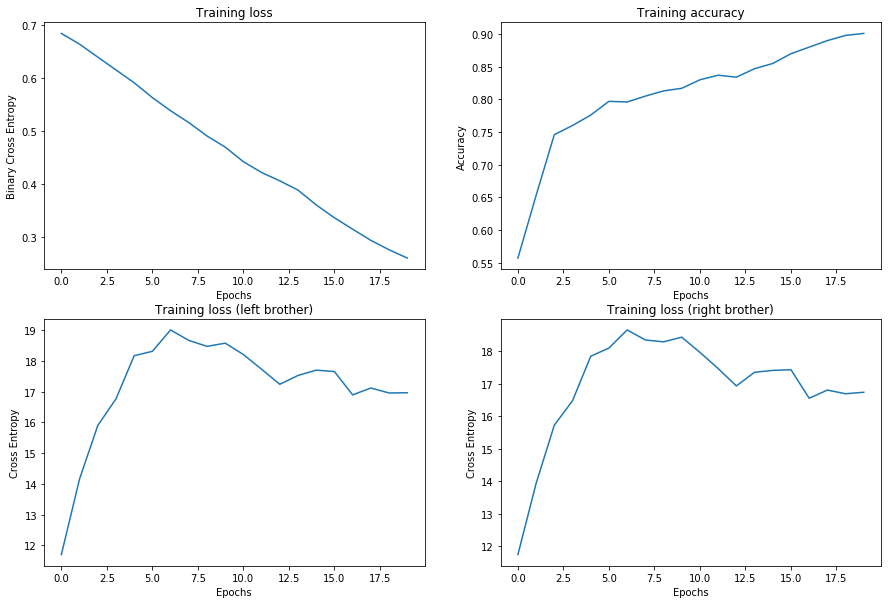

In [43]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), tr_loss8)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Training loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), tr_acc8)
plt.title('Training accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), tr_loss8_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), tr_loss8_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (right brother)')

Last test accuracy :0.792


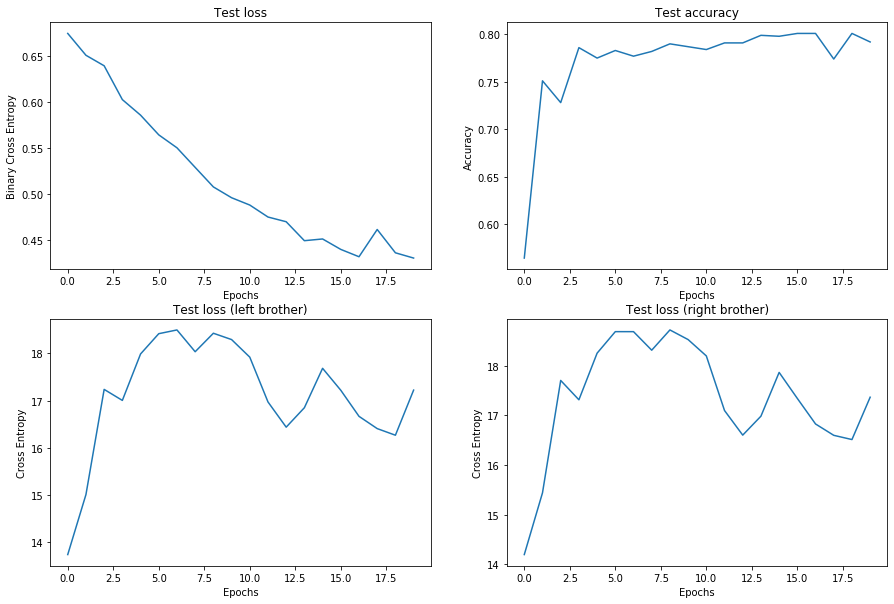

In [44]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), te_loss8)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Test loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), te_acc8)
plt.title('Test accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), te_loss8_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), te_loss8_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (right brother)')

print("Last test accuracy :" + str(te_acc8[-1]))

## Model 9: 
## Leonard model (Siamese with Roberts (Simple CNNs with FCNs for classification) - Weight sharing - Aux-loss)

In [45]:
robert9 = RobertNet(BASE_CHANNEL_SIZE, 1, NET_HIDDEN_LAYER)
model9 = LeonardNet(1, robert9, NET_HIDDEN_LAYER)

In [46]:
summary(model9, INPUT_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 12, 12]             160
         LeakyReLU-2           [-1, 16, 12, 12]               0
            Conv2d-3           [-1, 32, 10, 10]           4,640
         LeakyReLU-4           [-1, 32, 10, 10]               0
         MaxPool2d-5             [-1, 32, 5, 5]               0
            Linear-6                  [-1, 512]         410,112
            Linear-7                   [-1, 10]           5,130
         RobertNet-8       [[-1, 10], [-1, 10]]               0
            Conv2d-9           [-1, 16, 12, 12]             160
        LeakyReLU-10           [-1, 16, 12, 12]               0
           Conv2d-11           [-1, 32, 10, 10]           4,640
        LeakyReLU-12           [-1, 32, 10, 10]               0
        MaxPool2d-13             [-1, 32, 5, 5]               0
           Linear-14                  [

In [47]:
tr_loss9, tr_acc9, tr_loss9_l, tr_loss9_r, te_loss9, te_acc9, te_loss9_l, te_loss9_r = train_siamese(model = model9,
                                     dataloader = train_dataloader,
                                     test_dataloader = test_dataloader,
                                     epochs = EPOCHS,
                                     final_criterion = FINAL_CRITERION, 
                                     learning_rate = LEARNING_RATE,
                                     aux_loss = True,
                                     sub_criterion = SUB_CRITERION, 
                                     weights_loss = WEIGHTS_LOSS)

NO CUDA
[Epoch 1, Batch 0/1000]:  [Loss: 2.53]
[Epoch 1, Batch 250/1000]:  [Loss: 1.36]
[Epoch 1, Batch 500/1000]:  [Loss: 0.82]
[Epoch 1, Batch 750/1000]:  [Loss: 2.95]
At epoch 1 the training loss is 1.206240363717079
At epoch 1 the training accuracy is 0.557
At epoch 1 :
The test loss is 0.6743839383125305
The test accuracy is 0.628
[Epoch 2, Batch 0/1000]:  [Loss: 1.09]
[Epoch 2, Batch 250/1000]:  [Loss: 0.34]
[Epoch 2, Batch 500/1000]:  [Loss: 0.32]
[Epoch 2, Batch 750/1000]:  [Loss: 0.35]
At epoch 2 the training loss is 0.5963971476852894
At epoch 2 the training accuracy is 0.638
At epoch 2 :
The test loss is 0.5471831560134888
The test accuracy is 0.672
[Epoch 3, Batch 0/1000]:  [Loss: 0.40]
[Epoch 3, Batch 250/1000]:  [Loss: 0.36]
[Epoch 3, Batch 500/1000]:  [Loss: 0.34]
[Epoch 3, Batch 750/1000]:  [Loss: 0.32]
At epoch 3 the training loss is 0.4908209941983223
At epoch 3 the training accuracy is 0.683
At epoch 3 :
The test loss is 0.4844631850719452
The test accuracy is 0.673


Text(0.5, 1.0, 'Training loss (right brother)')

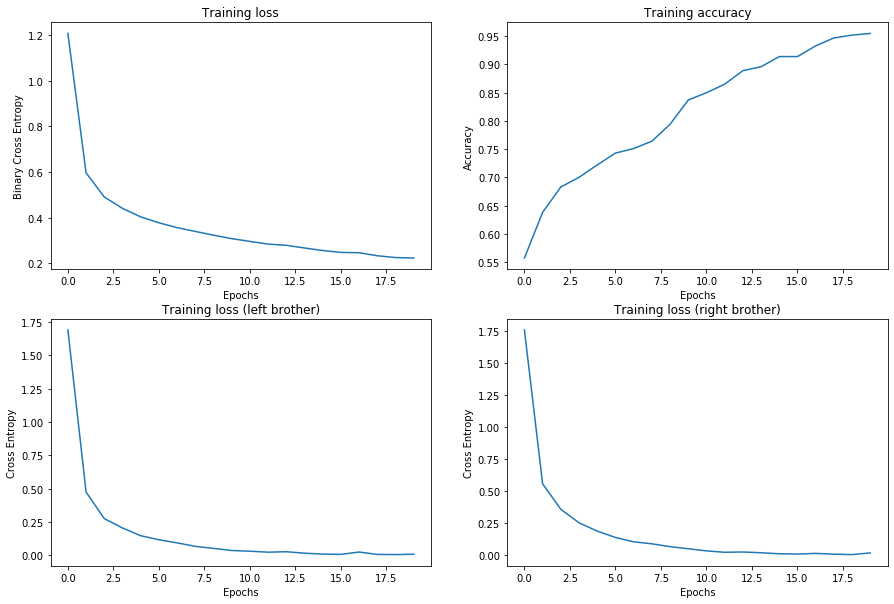

In [48]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), tr_loss9)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Training loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), tr_acc9)
plt.title('Training accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), tr_loss9_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), tr_loss9_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (right brother)')

Last test accuracy :0.924


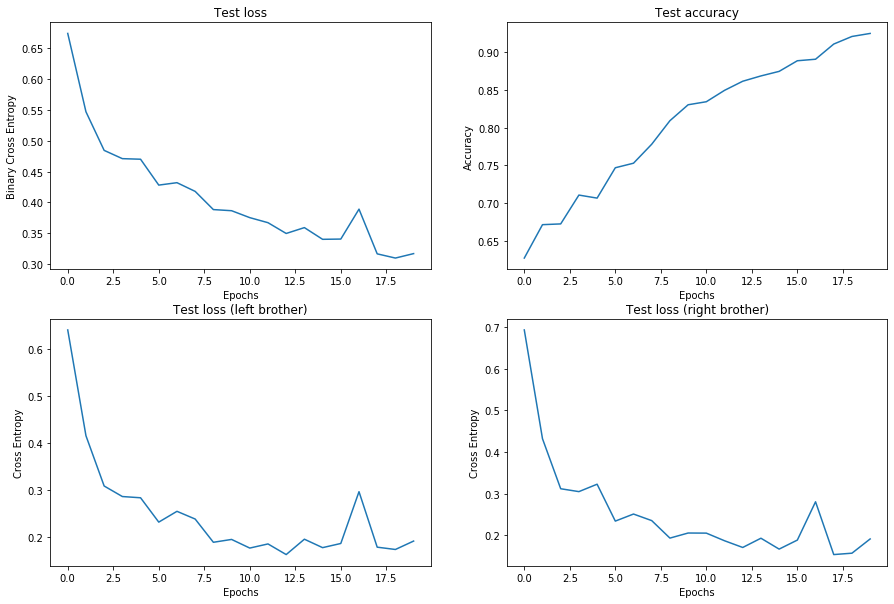

In [49]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), te_loss9)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Test loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), te_acc9)
plt.title('Test accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), te_loss9_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), te_loss9_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (right brother)')

print("Last test accuracy :" + str(te_acc9[-1]))